In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

In [12]:
# Primary Admissions information
df = pd.read_csv("ADMISSIONS.csv")

# Patient specific info such as gender
df_pat = pd.read_csv("Length_of_stay/PATIENTS.csv")

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv("Length_of_stay/DIAGNOSES_ICD.csv")

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv("Length_of_stay/ICUSTAYS.csv")

In [13]:
df

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,41055,44083,198330,2112-05-28 15:45:00,2112-06-07 16:50:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,SINGLE,WHITE,2112-05-28 13:16:00,2112-05-28 17:30:00,PERICARDIAL EFFUSION,0,1
125,41070,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,2178-05-14 17:37:00,2178-05-14 22:08:00,ALTERED MENTAL STATUS,1,1
126,41087,44212,163189,2123-11-24 14:14:00,2123-12-30 14:31:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,NaN,NaN,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...,0,1
127,41090,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,2180-07-19 04:50:00,2180-07-19 08:23:00,BRADYCARDIA,0,1


In [14]:
print('Dataset has {} number of unique admission events.'.format(df['hadm_id'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['subject_id'].nunique()))

Dataset has 129 number of unique admission events.
Dataset has 100 number of unique patients.


In [15]:
# Convert admission and discharge times to datatime type
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])

In [16]:
df.admittime

0     2164-10-23 21:09:00
1     2126-08-14 22:32:00
2     2125-10-04 23:36:00
3     2149-05-26 17:19:00
4     2163-05-14 20:43:00
              ...        
124   2112-05-28 15:45:00
125   2178-05-14 20:29:00
126   2123-11-24 14:14:00
127   2180-07-19 06:55:00
128   2170-12-15 03:14:00
Name: admittime, Length: 129, dtype: datetime64[ns]

In [17]:
# Calculating the Length of Stay variable using the difference between Discharge time and Admit time 
# Convert timedelta type into float 'days'. Note: There are 86400 seconds in a day
df['LOS'] = (df['dischtime'] - df['admittime']).dt.total_seconds()/86400

In [18]:
df['LOS'].describe()

count    129.000000
mean       9.332332
std       12.720450
min        0.038194
25%        3.314583
50%        6.634028
75%       10.645139
max      123.984722
Name: LOS, dtype: float64

In [19]:
df['LOS']

0       8.837500
1      13.852083
2       2.650694
3       8.057639
4       0.636806
         ...    
124    10.045139
125     0.552778
126    36.011806
127     1.253472
128     9.615278
Name: LOS, Length: 129, dtype: float64

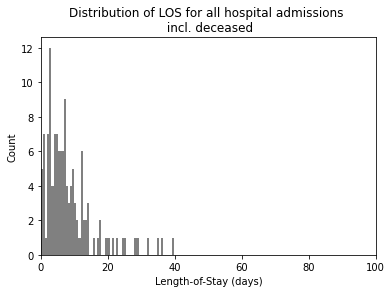

In [20]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '0.5')
plt.xlim(0, 100)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

In [21]:
# Dropping the columns that are not needed
df.drop(columns=['dischtime', 'row_id', 
                'edregtime', 'edouttime', 'hospital_expire_flag',
                'has_chartevents_data'], inplace=True)

In [22]:
df

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,diagnosis,LOS
0,10006,142345,2164-10-23 21:09:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,SEPSIS,8.837500
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,HEPATITIS B,13.852083
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,SEPSIS,2.650694
3,10017,199207,2149-05-26 17:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,HUMERAL FRACTURE,8.057639
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,ALCOHOLIC HEPATITIS,0.636806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,44083,198330,2112-05-28 15:45:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,SINGLE,WHITE,PERICARDIAL EFFUSION,10.045139
125,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,ALTERED MENTAL STATUS,0.552778
126,44212,163189,2123-11-24 14:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...,36.011806
127,44222,192189,2180-07-19 06:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,BRADYCARDIA,1.253472


In [23]:
# Mapping the dead and alive value of patients who died in hospital as 1 and 0
df['deceased'] = df['deathtime'].notnull().map({True:1, False:0})

In [24]:
print("{} of {} patients died in the hospital".format(df['deceased'].sum(), 
                                                     df['subject_id'].nunique()))

40 of 100 patients died in the hospital


In [25]:
# Descriptive analysis of patients who died during the stay in ICU
df['LOS'].loc[df['deceased'] == 0].describe()

count     89.000000
mean       9.766526
std       13.934030
min        0.980556
25%        4.104167
50%        6.830556
75%       10.146528
max      123.984722
Name: LOS, dtype: float64

In [26]:
# Club the Ethnicity categories into 5 broad categories
df['ethnicity'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ethnicity'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ethnicity'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ethnicity'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ethnicity'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ethnicity'].loc[~df['ethnicity'].isin(df['ethnicity'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ethnicity'].value_counts()

C:\Users\neetu\anaconda3\envs\master\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


WHITE                                                       86
OTHER/UNKNOWN                                               17
HISPANIC/LATINO                                             17
BLACK/AFRICAN AMERICAN                                       7
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE     2
Name: ethnicity, dtype: int64

In [27]:
# Bar plot function
def plot_los_groupby(variable, size=(7,4)):
    
    #Plot Median LOS by df categorical series name 
    
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    
    #Boxplot of LOS by df categorical series name 
    
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();



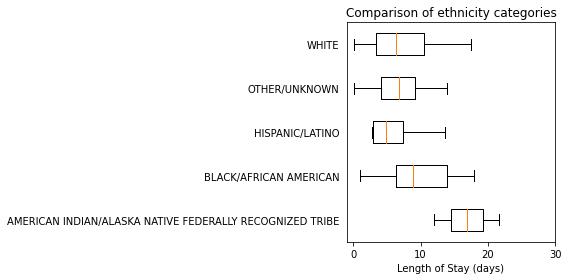

In [28]:
boxplot_los_groupby('ethnicity', los_range=(-1, 30))

In [29]:
df['admission_type'].value_counts()

EMERGENCY    119
ELECTIVE       8
URGENT         2
Name: admission_type, dtype: int64

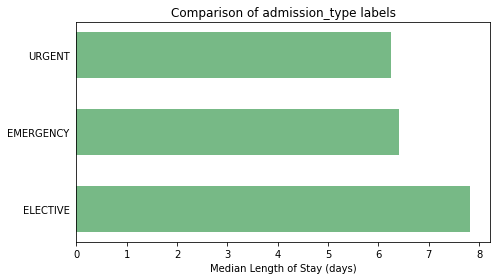

In [30]:
plot_los_groupby('admission_type')

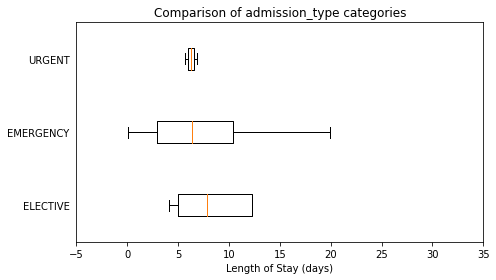

In [31]:
boxplot_los_groupby('admission_type', los_range=(-5, 35), size=(7, 4))

In [32]:
df['insurance'].value_counts()

Medicare      98
Private       24
Medicaid       6
Government     1
Name: insurance, dtype: int64

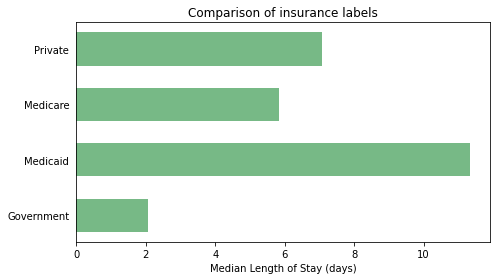

In [33]:
plot_los_groupby('insurance')

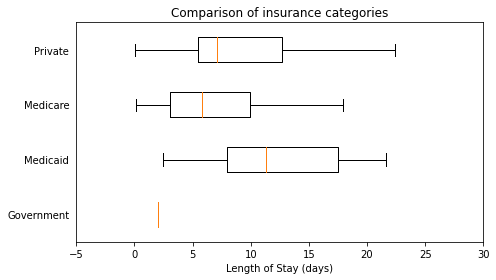

In [34]:
boxplot_los_groupby('insurance', los_range=(-5, 30), size=(7, 4))

In [35]:
df['marital_status'].value_counts(dropna=False)

MARRIED              60
SINGLE               26
NaN                  16
WIDOWED              15
DIVORCED              6
UNKNOWN (DEFAULT)     5
SEPARATED             1
Name: marital_status, dtype: int64

In [36]:
# Replacing NAs as'UNKNOWN'
df['marital_status'] = df['marital_status'].fillna('UNKNOWN (DEFAULT)')
df['marital_status'].value_counts(dropna=False)

MARRIED              60
SINGLE               26
UNKNOWN (DEFAULT)    21
WIDOWED              15
DIVORCED              6
SEPARATED             1
Name: marital_status, dtype: int64

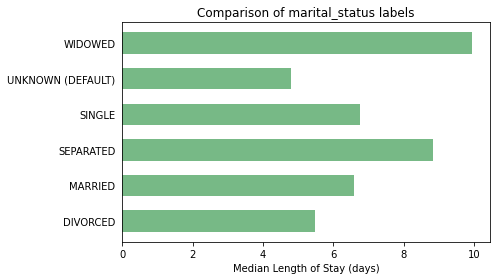

In [37]:
plot_los_groupby('marital_status')

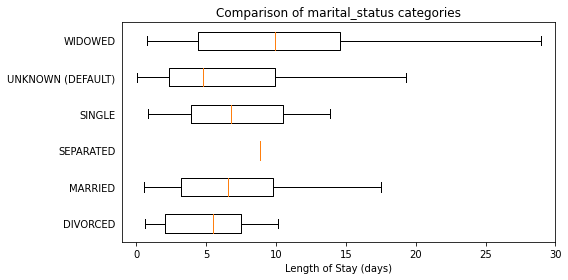

In [38]:
boxplot_los_groupby('marital_status')

In [39]:
df

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,diagnosis,LOS,deceased
0,10006,142345,2164-10-23 21:09:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,SEPSIS,8.837500,0
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,OTHER/UNKNOWN,HEPATITIS B,13.852083,1
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,UNKNOWN (DEFAULT),OTHER/UNKNOWN,SEPSIS,2.650694,1
3,10017,199207,2149-05-26 17:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,HUMERAL FRACTURE,8.057639,0
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,ALCOHOLIC HEPATITIS,0.636806,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,44083,198330,2112-05-28 15:45:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,SINGLE,WHITE,PERICARDIAL EFFUSION,10.045139,0
125,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,ALTERED MENTAL STATUS,0.552778,1
126,44212,163189,2123-11-24 14:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...,36.011806,0
127,44222,192189,2180-07-19 06:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,BRADYCARDIA,1.253472,0


## DIAGNOSES_ICD Dataset

Because it's not feasible to have 6985 unique values to use as features for predicting LOS, The diagnosis were reduced into more general categories. After researching the ICD9 coding methodology, the super categories in which the diagnosis codes are arranged are as follows:

001–139: infectious and parasitic diseases\
140–239: neoplasms\
240–279: endocrine, nutritional and metabolic diseases, and immunity disorders\
280–289: diseases of the blood and blood-forming organs\
290–319: mental disorders\
320–389: diseases of the nervous system and sense organs\
390–459: diseases of the circulatory system\
460–519: diseases of the respiratory system\
520–579: diseases of the digestive system\
580–629: diseases of the genitourinary system\
630–679: complications of pregnancy, childbirth, and the puerperium\
680–709: diseases of the skin and subcutaneous tissue\
710–739: diseases of the musculoskeletal system and connective tissue\
740–759: congenital anomalies\
760–779: certain conditions originating in the perinatal period\
780–799: symptoms, signs, and ill-defined conditions\
800–999: injury and poisoning\
E and V codes: external causes of injury and supplemental classification, using 999 as placeholder even though it overlaps with complications of medical care\
Source of these categories: https://en.wikipedia.org/wiki/List_of_ICD-9_codes

In [40]:
df_diagcode

,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731
...,...,...,...,...,...
1756,397673,44228,103379,7,1975
1757,397674,44228,103379,8,45182
1758,397675,44228,103379,9,99592
1759,397676,44228,103379,10,2449


In [41]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['icd9_code']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

In [42]:
df_diagcode

,row_id,subject_id,hadm_id,seq_num,icd9_code,recode
0,112344,10006,142345,1,99591,99591
1,112345,10006,142345,2,99662,99662
2,112346,10006,142345,3,5672,5672
3,112347,10006,142345,4,40391,40391
4,112348,10006,142345,5,42731,42731
...,...,...,...,...,...,...
1756,397673,44228,103379,7,1975,1975
1757,397674,44228,103379,8,45182,45182
1758,397675,44228,103379,9,99592,99592
1759,397676,44228,103379,10,2449,2449


In [43]:
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [44]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
            num, df_diagcode['recode'])
    
# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [45]:
df_diagcode

,row_id,subject_id,hadm_id,seq_num,icd9_code,recode,cat
0,112344,10006,142345,1,99591,16,injury
1,112345,10006,142345,2,99662,16,injury
2,112346,10006,142345,3,5672,8,digestive
3,112347,10006,142345,4,40391,6,circulatory
4,112348,10006,142345,5,42731,6,circulatory
...,...,...,...,...,...,...,...
1756,397673,44228,103379,7,1975,1,neoplasms
1757,397674,44228,103379,8,45182,6,circulatory
1758,397675,44228,103379,9,99592,16,injury
1759,397676,44228,103379,10,2449,2,endocrine


In [46]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('hadm_id')['cat'].apply(list).reset_index()

In [47]:
hadm_list

,hadm_id,cat
0,100375,"[infectious, genitourinary, genitourinary, end..."
1,100969,"[circulatory, nervous, respiratory, respirator..."
2,101361,"[injury, respiratory, respiratory, respiratory..."
3,102203,"[digestive, genitourinary, misc, endocrine, di..."
4,103379,"[infectious, misc, respiratory, infectious, ne..."
...,...,...
124,198330,"[circulatory, respiratory, circulatory, blood,..."
125,198480,"[digestive, genitourinary, digestive, digestiv..."
126,198503,"[respiratory, neoplasms, neoplasms, genitourin..."
127,199207,"[injury, respiratory, injury, injury, injury, ..."


In [48]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()

In [49]:
hadm_item

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin
0,0,2,0,0,2,2,1,1,0,1,0,0,0,0,0,0
1,0,4,0,0,1,0,0,0,1,0,0,0,1,0,3,0
2,1,2,0,1,2,1,2,11,1,0,0,0,1,0,5,4
3,0,0,0,4,3,1,0,1,1,1,0,0,0,0,0,0
4,1,1,0,0,1,0,2,1,0,1,0,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,1,3,0,0,0,0,0,1,0,0,0,0,0,0,1,0
125,1,3,0,4,4,1,1,2,0,0,0,0,1,0,2,0
126,1,0,0,0,3,1,1,2,0,1,0,4,0,0,2,0
127,1,2,0,0,2,0,0,7,0,0,0,0,0,0,2,0


In [50]:
# Join the above created dataset using hadm_id to the hadm_list
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")

In [51]:
hadm_item

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,hadm_id
0,0,2,0,0,2,2,1,1,0,1,0,0,0,0,0,0,100375
1,0,4,0,0,1,0,0,0,1,0,0,0,1,0,3,0,100969
2,1,2,0,1,2,1,2,11,1,0,0,0,1,0,5,4,101361
3,0,0,0,4,3,1,0,1,1,1,0,0,0,0,0,0,102203
4,1,1,0,0,1,0,2,1,0,1,0,3,0,0,1,0,103379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,1,3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,198330
125,1,3,0,4,4,1,1,2,0,0,0,0,1,0,2,0,198480
126,1,0,0,0,3,1,1,2,0,1,0,4,0,0,2,0,198503
127,1,2,0,0,2,0,0,7,0,0,0,0,0,0,2,0,199207


In [52]:
# Finally merging with main admissions df
df = df.merge(hadm_item, how='inner', on="hadm_id")

In [53]:
df

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,...,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin
0,10006,142345,2164-10-23 21:09:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,...,1,6,1,1,0,0,0,0,0,0
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,...,2,0,1,0,0,0,0,0,0,0
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,...,1,0,0,1,0,1,0,0,1,0
3,10017,199207,2149-05-26 17:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,...,0,7,0,0,0,0,0,0,2,0
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,...,1,1,1,1,1,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,44083,198330,2112-05-28 15:45:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,...,0,1,0,0,0,0,0,0,1,0
125,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,...,1,1,0,0,2,0,1,0,2,0
126,44212,163189,2123-11-24 14:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,...,2,1,0,2,0,0,1,0,2,2
127,44222,192189,2180-07-19 06:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,...,0,1,0,0,1,0,2,0,0,0


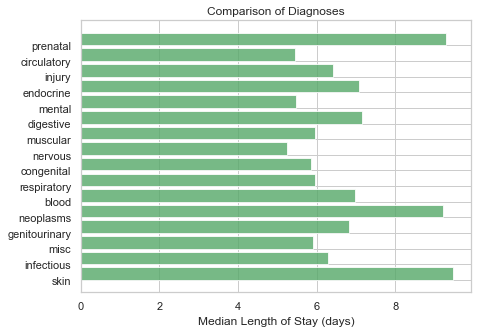

In [54]:
# Explore median LOS by diagnosis category as defined above
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

## ICUSTAYS Dataset

In [55]:
df_icu['hadm_id'].nunique()

129

In [56]:
df_icu

,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,10006,142345,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10,2164-10-25 12:21,1.6325
1,10011,105331,232110,carevue,MICU,MICU,15,15,2126-08-14 22:34,2126-08-28 18:59,13.8507
2,10013,165520,264446,carevue,MICU,MICU,15,15,2125-10-04 23:38,2125-10-07 15:13,2.6499
3,10017,199207,204881,carevue,CCU,CCU,7,7,2149-05-29 18:52,2149-05-31 22:19,2.1436
4,10019,177759,228977,carevue,MICU,MICU,15,15,2163-05-14 20:43,2163-05-16 3:47,1.2938
...,...,...,...,...,...,...,...,...,...,...,...
131,44083,198330,286428,metavision,CCU,CCU,7,7,2112-05-29 2:01,2112-06-01 16:50,3.6174
132,44154,174245,217724,metavision,MICU,MICU,50,50,2178-05-14 20:29,2178-05-15 11:31,0.6259
133,44212,163189,239396,metavision,MICU,MICU,50,50,2123-11-24 14:14,2123-12-25 17:12,31.1235
134,44222,192189,238186,metavision,CCU,CCU,7,7,2180-07-19 6:56,2180-07-20 14:48,1.3279


In [57]:
# Converting different categories of first care unit into ICU and NICU groups
df_icu['first_careunit'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [58]:
df_icu['cat'] = df_icu['first_careunit']
icu_list = df_icu.groupby('hadm_id')['cat'].apply(list).reset_index()

In [59]:
df_icu['first_careunit'].value_counts()

ICU    136
Name: first_careunit, dtype: int64

In [60]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['hadm_id'], how="outer")

In [61]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='hadm_id')

In [62]:
# Replace NA with 0
df['ICU'].fillna(value=0, inplace=True)

In [63]:
df

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,...,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,ICU
0,10006,142345,2164-10-23 21:09:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,...,6,1,1,0,0,0,0,0,0,1
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,...,0,1,0,0,0,0,0,0,0,1
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,...,0,0,1,0,1,0,0,1,0,1
3,10017,199207,2149-05-26 17:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,...,7,0,0,0,0,0,0,2,0,1
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,...,1,1,1,1,0,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,44083,198330,2112-05-28 15:45:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,...,1,0,0,0,0,0,0,1,0,1
125,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,...,1,0,0,2,0,1,0,2,0,1
126,44212,163189,2123-11-24 14:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,...,1,0,2,0,0,1,0,2,2,1
127,44222,192189,2180-07-19 06:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,...,1,0,0,1,0,2,0,0,0,1


In [64]:
# Drop unnecessary columns
df.drop(columns=['admission_location','subject_id', 'hadm_id', 'admittime', 'admission_location',
               'discharge_location', 'language',
               'diagnosis', 'deceased',  'deathtime'], inplace=True)
df.drop(columns=['dob','dod','dod_hosp','dod_ssn','rowid','religion'], inplace=True)

KeyError: "['dob' 'dod' 'dod_hosp' 'dod_ssn' 'rowid'] not found in axis"

In [65]:
df

,admission_type,insurance,religion,marital_status,ethnicity,LOS,blood,circulatory,congenital,digestive,...,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,ICU
0,EMERGENCY,Medicare,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,8.837500,2,6,0,2,...,6,1,1,0,0,0,0,0,0,1
1,EMERGENCY,Private,CATHOLIC,SINGLE,OTHER/UNKNOWN,13.852083,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,EMERGENCY,Medicare,CATHOLIC,UNKNOWN (DEFAULT),OTHER/UNKNOWN,2.650694,0,4,0,0,...,0,0,1,0,1,0,0,1,0,1
3,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,8.057639,1,2,0,0,...,7,0,0,0,0,0,0,2,0,1
4,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0.636806,1,1,0,4,...,1,1,1,1,0,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,10.045139,1,3,0,0,...,1,0,0,0,0,0,0,1,0,1
125,EMERGENCY,Medicare,PROTESTANT QUAKER,MARRIED,WHITE,0.552778,0,2,0,0,...,1,0,0,2,0,1,0,2,0,1
126,EMERGENCY,Medicare,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,36.011806,2,2,0,6,...,1,0,2,0,0,1,0,2,2,1
127,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,1.253472,0,3,0,0,...,1,0,0,1,0,2,0,0,0,1


In [66]:
# Filtering only admission with LOS less than 40 days to reduce the skewness of the data.
df = df[df['LOS'] <40]

In [67]:
# Randomly splitting the data into test and train with 20% and 80% distribution. Using the train data to generate
# synthetic data and keeping the test data seperate for evaluation purpose

los_use, los_predict = train_test_split(df, test_size=0.2, random_state=25)

In [68]:
# Writing the train and test files into csv for further use 
# Note: Train dataset will be used for generating synthetic data using T-GAN and CT-GAN.
# Test dataset will be used for evaluation of models

los_use.to_csv("los_usecase.csv",index = False)
los_predict.to_csv("los_predict.csv",index = False)

In [69]:
!pip install tensorflow 

  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=0e5cd58deb6b85e21a511b4c62940289429fa20ce11415d0fe8c13c96ccd43b7
  Stored in directory: c:\users\neetu\appdata\local\pip\cache\wheels\22\4c\94\0583f60c9c5b6024ed64f290cb2d43b06bb4f75577dc3c93a7
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=498bc8a791d0aadf75bd230706aa8425db74dbf573f8ebc0425065df1fd9af94
  Stored in directory: c:\users\neetu\appdata\local\pip\cache\wheels\93\2a\eb\e58dbcbc963549ee4f065ff80a59f274cc7210b6eab962acdc
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19572 sha256=3031e63edd20cfd7115dc4fcef839313e1697a6b8bc786824f231c4e18794884
  Stored in directory: c:\users\neetu\appdata\local\pip\cache\wheels\32\42\7f\23cae9ff6ef66798d00dc5d659088e57dbba01566f6c60db63
Successfully built clang termcolor wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing

In [70]:
pip install tensorflow 

Note: you may need to restart the kernel to use updated packages.


In [71]:
df

,admission_type,insurance,religion,marital_status,ethnicity,LOS,blood,circulatory,congenital,digestive,...,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,ICU
0,EMERGENCY,Medicare,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,8.837500,2,6,0,2,...,6,1,1,0,0,0,0,0,0,1
1,EMERGENCY,Private,CATHOLIC,SINGLE,OTHER/UNKNOWN,13.852083,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,EMERGENCY,Medicare,CATHOLIC,UNKNOWN (DEFAULT),OTHER/UNKNOWN,2.650694,0,4,0,0,...,0,0,1,0,1,0,0,1,0,1
3,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,8.057639,1,2,0,0,...,7,0,0,0,0,0,0,2,0,1
4,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0.636806,1,1,0,4,...,1,1,1,1,0,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,10.045139,1,3,0,0,...,1,0,0,0,0,0,0,1,0,1
125,EMERGENCY,Medicare,PROTESTANT QUAKER,MARRIED,WHITE,0.552778,0,2,0,0,...,1,0,0,2,0,1,0,2,0,1
126,EMERGENCY,Medicare,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,36.011806,2,2,0,6,...,1,0,2,0,0,1,0,2,2,1
127,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,1.253472,0,3,0,0,...,1,0,0,1,0,2,0,0,0,1


## Use Case 2: Mortality Prediction

In [73]:
patients = pd.read_csv("mimic-iii/patients.csv")
admissions = pd.read_csv("mimic-iii/admissions.csv")
callout = pd.read_csv("mimic-iii/callout.csv")
cptevents = pd.read_csv("mimic-iii/cptevents.csv")
diagnosis = pd.read_csv("mimic-iii/diagnoses_icd.csv")
outputevents = pd.read_csv("mimic-iii/outputevents.csv")
rx = pd.read_csv("mimic-iii/prescriptions.csv")
procevents = pd.read_csv("mimic-iii/procedureevents_mv.csv")
microlabevents = pd.read_csv("mimic-iii/microbiologyevents.csv")
proc = pd.read_csv("mimic-iii/procedures_icd.csv")
transfers = pd.read_csv("mimic-iii/transfers.csv")
inputevents = pd.read_csv("mimic-iii/inputevents_cv.csv")
labevents = pd.read_csv("mimic-iii/labevents.csv")
noteevents = pd.read_csv("mimic-iii/noteevents.csv")

C:\Users\neetu\anaconda3\envs\master\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (17,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
callout

,row_id,subject_id,hadm_id,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_tele,...,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,firstreservationtime,currentreservationtime
0,3917,10017,199207,7,NaN,45,CCU,1,MED,1,...,Inactive,Discharged,45.0,Acknowledged,2149-05-31 10:44:34,2149-05-31 10:44:34,2149-05-31 15:08:04,2149-05-31 22:40:02,NaN,NaN
1,3919,10026,103770,33,NaN,3,SICU,3,NMED,1,...,Inactive,Discharged,3.0,Revised,2195-05-18 13:56:20,2195-05-19 15:45:30,NaN,2195-05-19 17:40:03,NaN,NaN
2,3920,10027,199395,12,NaN,55,CSRU,55,CSURG,1,...,Inactive,Discharged,55.0,Acknowledged,2190-07-20 08:15:20,2190-07-20 08:15:20,2190-07-20 08:57:46,2190-07-20 17:10:02,NaN,NaN
3,3921,10029,132349,33,NaN,45,SICU,1,MED,0,...,Inactive,Discharged,45.0,Acknowledged,2139-09-24 09:53:37,2139-09-24 09:53:37,2139-09-24 09:56:02,2139-09-25 19:10:01,NaN,NaN
4,3922,10033,157235,33,NaN,4,SICU,1,MED,1,...,Inactive,Discharged,4.0,Revised,2132-12-06 10:16:08,2132-12-06 14:53:53,NaN,2132-12-06 15:10:02,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,17090,44083,125157,33,NaN,36,SICU,1,TSURG,0,...,Inactive,Discharged,36.0,Acknowledged,2112-05-06 10:26:20,2112-05-06 10:26:20,2112-05-06 10:33:25,2112-05-06 17:40:09,2112-05-06 15:40:09,NaN
73,17091,44083,131048,7,CCU,7,CCU,17,CCU,1,...,Inactive,Cancelled,NaN,Acknowledged,2112-05-24 16:27:05,2112-05-24 18:45:28,2112-05-24 17:42:04,2112-05-24 18:45:28,2112-05-24 17:55:07,2112-05-24 17:55:07
74,17092,44083,198330,7,NaN,36,CCU,36,TSURG,1,...,Inactive,Discharged,36.0,Acknowledged,2112-06-01 12:31:12,2112-06-01 12:31:12,2112-06-01 12:32:42,2112-06-01 17:10:08,2112-06-01 12:40:07,NaN
75,17120,44212,163189,50,NaN,55,MICU,1,MED,0,...,Inactive,Discharged,55.0,Acknowledged,2123-12-25 10:29:39,2123-12-25 10:29:39,2123-12-25 11:33:42,2123-12-25 17:25:04,2123-12-25 12:10:04,2123-12-25 12:10:04


### Function to roll up tables

In [75]:
def rollup_sub_adm(df1,col):
    df1=df1.groupby(['subject_id','hadm_id']).agg({'row_id':'count'})
    df1.reset_index(inplace=True)
    df1.columns=['subject_id','hadm_id',col]
    print(col,":",df1.shape)
    return df1

In [76]:
callout=rollup_sub_adm(callout,'NUMCALLOUT')
cptevents=rollup_sub_adm(cptevents,'NUMCPTEVENTS')
diagnosis=rollup_sub_adm(diagnosis,'NUMDIAGNOSIS')
outputevents=rollup_sub_adm(outputevents,'NUMOUTEVENTS')
rx=rollup_sub_adm(rx,'NUMRX')
procevents=rollup_sub_adm(procevents,'NUMPROCEVENTS')
microlabevents=rollup_sub_adm(microlabevents,'NUMMICROLABEVENTS')
proc=rollup_sub_adm(proc,'NUMPROC')
transfers=rollup_sub_adm(transfers,'NUMTRANSFERS')
inputevents=rollup_sub_adm(inputevents,'NUMINPUTEVENTS')
labevents=rollup_sub_adm(labevents,'NUMLABEVENTS')
noteevents=rollup_sub_adm(noteevents,'NUMNOTEVENTS')

NUMCALLOUT : (67, 3)
NUMCPTEVENTS : (118, 3)
NUMDIAGNOSIS : (129, 3)
NUMOUTEVENTS : (123, 3)
NUMRX : (122, 3)
NUMPROCEVENTS : (70, 3)
NUMMICROLABEVENTS : (120, 3)
NUMPROC : (113, 3)
NUMTRANSFERS : (129, 3)
NUMINPUTEVENTS : (55, 3)
NUMLABEVENTS : (129, 3)
NUMNOTEVENTS : (0, 3)


In [77]:
mortality=admissions[['subject_id','hadm_id','admission_type','marital_status','ethnicity','hospital_expire_flag']]
mortality.loc[pd.isnull(mortality['marital_status']),'marital_status'] ='UNKNOWN (DEFAULT)'
mortality = mortality.merge(patients[['subject_id','gender']],how='left',on='subject_id')
mortality = mortality.merge(callout,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(cptevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(diagnosis,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(outputevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(rx,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(procevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(microlabevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(proc,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(transfers,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(inputevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(labevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(noteevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.fillna(0)

C:\Users\neetu\anaconda3\envs\master\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [78]:
#Exporing data
mortality.to_csv('mortality_full_data.csv',index=False)

### Exploratory Analysis

In [79]:
mortality.shape

(129, 19)

In [80]:
mortality.columns

Index(['subject_id', 'hadm_id', 'admission_type', 'marital_status',
       'ethnicity', 'hospital_expire_flag', 'gender', 'NUMCALLOUT',
       'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS'],
      dtype='object')

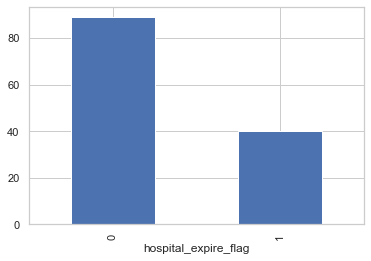

In [81]:
mortality.groupby('hospital_expire_flag').size().plot.bar()
plt.show()

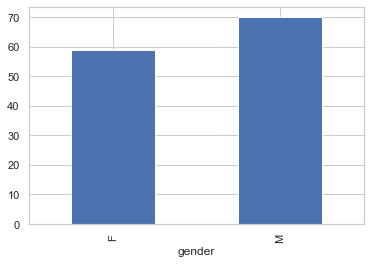

In [82]:
mortality.groupby('gender').size().plot.bar()
plt.show()

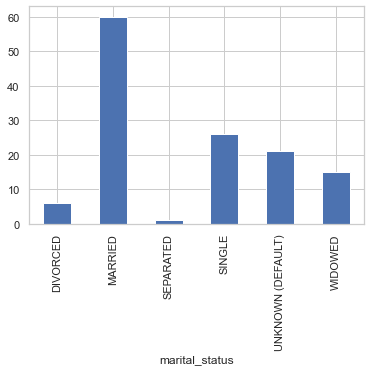

In [83]:
mortality.groupby('marital_status').size().plot.bar()
plt.show()

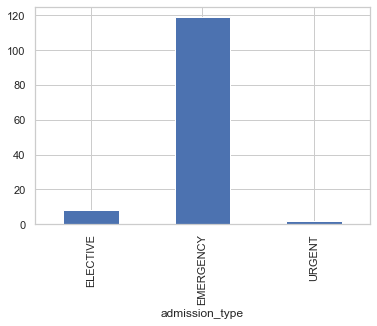

In [84]:
mortality.groupby('admission_type').size().plot.bar()
plt.show()

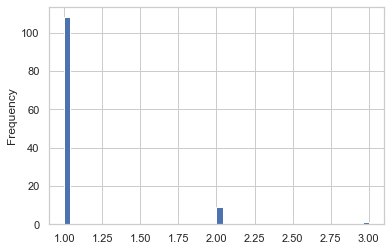

In [85]:
mortality.groupby('NUMLABEVENTS').size().plot.hist(bins=50)
plt.show()

In [86]:
mortality.dtypes

subject_id                int64
hadm_id                   int64
admission_type           object
marital_status           object
ethnicity                object
hospital_expire_flag      int64
gender                   object
NUMCALLOUT              float64
NUMCPTEVENTS            float64
NUMDIAGNOSIS              int64
NUMOUTEVENTS            float64
NUMRX                   float64
NUMPROCEVENTS           float64
NUMMICROLABEVENTS       float64
NUMPROC                 float64
NUMTRANSFERS              int64
NUMINPUTEVENTS          float64
NUMLABEVENTS              int64
NUMNOTEVENTS            float64
dtype: object

## TGAN for 2nd use case Mortality Prediction

In [89]:
pip install tgan

  Using cached tgan-0.1.0-py2.py3-none-any.whl (27 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-1.15.5-cp36-cp36m-win_amd64.whl (55.3 MB)
  Using cached tensorpack-0.9.4-py2.py3-none-any.whl (273 kB)
  Using cached msgpack-1.0.5-cp36-cp36m-win_amd64.whl (69 kB)
  Using cached msgpack_numpy-0.4.8-py2.py3-none-any.whl (6.9 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached tabulate-0.8.10-py3-none-any.whl (29 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Using cached h5py-2.10.0-cp36-cp36m-win_amd64.whl (2.4 MB)
  Using cached gast-0.2.2-py3-none-any.whl
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Using cached importlib_resources-5.4.0-py3-none-any.whl (28 kB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstall

In [90]:
mortality

,subject_id,hadm_id,admission_type,marital_status,ethnicity,hospital_expire_flag,gender,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS
0,10006,142345,EMERGENCY,SEPARATED,BLACK/AFRICAN AMERICAN,0,F,0.0,4.0,21,3.0,54.0,0.0,20.0,7.0,3,6.0,251,0.0
1,10011,105331,EMERGENCY,SINGLE,UNKNOWN/NOT SPECIFIED,1,F,0.0,0.0,6,261.0,0.0,0.0,13.0,2.0,2,573.0,700,0.0
2,10013,165520,EMERGENCY,UNKNOWN (DEFAULT),UNKNOWN/NOT SPECIFIED,1,F,0.0,1.0,9,32.0,36.0,0.0,3.0,1.0,2,430.0,148,0.0
3,10017,199207,EMERGENCY,DIVORCED,WHITE,0,F,1.0,13.0,14,25.0,105.0,0.0,2.0,2.0,6,163.0,302,0.0
4,10019,177759,EMERGENCY,DIVORCED,WHITE,1,M,0.0,5.0,14,22.0,99.0,0.0,13.0,4.0,2,821.0,287,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,44083,198330,EMERGENCY,SINGLE,WHITE,0,M,1.0,5.0,6,56.0,66.0,9.0,14.0,4.0,5,0.0,206,0.0
125,44154,174245,EMERGENCY,MARRIED,WHITE,1,M,0.0,4.0,9,8.0,40.0,6.0,3.0,1.0,3,0.0,157,0.0
126,44212,163189,EMERGENCY,SINGLE,BLACK/AFRICAN AMERICAN,0,F,1.0,88.0,24,211.0,209.0,59.0,34.0,7.0,3,0.0,3093,0.0
127,44222,192189,EMERGENCY,SINGLE,WHITE,0,M,0.0,2.0,11,7.0,19.0,5.0,1.0,0.0,2,0.0,86,0.0


In [93]:
continuous_columns = ['NUMCALLOUT','NUMCPTEVENTS', 'NUMOUTEVENTS','NUMRX','NUMPROCEVENTS','NUMMICROLABEVENTS','NUMPROC','NUMINPUTEVENTS','NUMNOTEVENTS']

In [94]:
continuous_columns

['NUMCALLOUT',
 'NUMCPTEVENTS',
 'NUMOUTEVENTS',
 'NUMRX',
 'NUMPROCEVENTS',
 'NUMMICROLABEVENTS',
 'NUMPROC',
 'NUMINPUTEVENTS',
 'NUMNOTEVENTS']

In [96]:
!pip install tensor2tensor==1.14.0

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached tensorflow-2.6.2-cp36-cp36m-win_amd64.whl (423.3 MB)
INFO: pip is looking at multiple versions of kfac to determine which version is compatible with other requirements. This could take a while.
  Created wheel for bz2file: filename=bz2file-0.98-py3-none-any.whl size=6882 sha256=fc1bbb49938e2e456ac4cdd0927b9f0885280bdfa9096dbde3191a7647c75966
  Stored in direc

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\neetu\anaconda3\envs\master\python.exe' 'C:\Users\neetu\anaconda3\envs\master\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' build_wheel 'C:\Users\neetu\AppData\Local\Temp\tmpvf8wju9s'
       cwd: C:\Users\neetu\AppData\Local\Temp\pip-install-73p_s8i2\opencv-python_16ca3db83e4c4b48bed69f1624bb8e55
  Complete output (395 lines):
  
  
  --------------------------------------------------------------------------------
  -- Trying 'Ninja (Visual Studio 17 2022 x64 v143)' generator
  --------------------------------
  ---------------------------
  ----------------------
  -----------------
  ------------
  -------
  --
  Not searching for unused variables given on the command line.
  CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
    Compatibility with CMake < 3.5 will be removed from a future version of
    CMake.
  
    Update the VERSION argument <min> value or use a ...<max> 

In [98]:
from tgan.model import TGANModel

In [110]:
tgan = TGANModel(continuous_columns,batch_size=129)

In [111]:
tgan.batch_size

129

In [112]:
data = pd.read_csv("mortality_full_data.csv")

In [113]:
tgan.fit(data)




[0208 22:35:43 @input_source.py:222] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...








Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[0208 22:35:43 @registry.py:126] gen/LSTM/00/FC input: [129, 100]

Instructions for updating:
Please use `layer.__call__` method instead.
[0208 22:35:43 @registry.py:134] gen/LSTM/00/FC output: [129, 100]
[0208 22:35:43 @registry.py:126] gen/LSTM/00/FC2 input: [129, 100]
[0208 22:35:43 @registry.py:134] gen/LSTM/00/FC2 output: [129, 100]
[0208 22:35:43 @registry.py:126] gen/LSTM/00/FC3 input: [129, 100]
[0208 22:35:43 @registry.py:134] gen/LSTM/00/FC3 output: [129, 100]
[0208 22:35:43 @registry.py:126] gen/LSTM/01/FC input: [129, 100]
[0208 22:35:43 @regis

[0208 22:35:44 @registry.py:134] gen/LSTM/09/FC2 output: [129, 26]
[0208 22:35:44 @registry.py:126] gen/LSTM/09/FC3 input: [129, 26]
[0208 22:35:44 @registry.py:134] gen/LSTM/09/FC3 output: [129, 100]
[0208 22:35:44 @registry.py:126] gen/LSTM/10/FC input: [129, 100]
[0208 22:35:44 @registry.py:134] gen/LSTM/10/FC output: [129, 100]
[0208 22:35:44 @registry.py:126] gen/LSTM/10/FC2 input: [129, 100]
[0208 22:35:44 @registry.py:134] gen/LSTM/10/FC2 output: [129, 78]
[0208 22:35:44 @registry.py:126] gen/LSTM/10/FC3 input: [129, 78]
[0208 22:35:44 @registry.py:134] gen/LSTM/10/FC3 output: [129, 100]
[0208 22:35:44 @registry.py:126] gen/LSTM/11/FC input: [129, 100]
[0208 22:35:44 @registry.py:134] gen/LSTM/11/FC output: [129, 100]
[0208 22:35:44 @registry.py:126] gen/LSTM/11/FC2 input: [129, 100]
[0208 22:35:44 @registry.py:134] gen/LSTM/11/FC2 output: [129, 80]
[0208 22:35:44 @registry.py:126] gen/LSTM/11/FC3 input: [129, 80]
[0208 22:35:44 @registry.py:134] gen/LSTM/11/FC3 output: [129, 10

[0208 22:35:51 @base.py:209] Setup callbacks graph ...






[0208 22:35:51 @summary.py:46] [MovingAverageSummary] 6 operations in collection 'MOVING_SUMMARY_OPS' will be run with session hooks.
[0208 22:35:51 @summary.py:93] Summarizing collection 'summaries' of size 9.

[0208 22:35:51 @graph.py:98] Applying collection UPDATE_OPS of 4 ops.

[0208 22:35:53 @base.py:230] Creating the session ...


Instructions for updating:
Please use tensorflow.python.ops.op_selector.get_backward_walk_ops.



[0208 22:35:55 @base.py:236] Initializing the session ...
[0208 22:35:55 @base.py:243] Graph Finalized.


[0208 22:35:55 @concurrency.py:38] Starting EnqueueThread QueueInput/input_queue ...

[0208 22:35:56 @base.py:275] Start Epoch 1 ...


100%|#########9|9998/10000[41:23<00:00, 4.11it/s]   

100%|##########|10000/10000[41:26<00:00, 4.02it/s]

[0208 23:17:23 @base.py:285] Epoch 1 (global_step 10000) finished, time:41 minutes 26 seconds.



[0208 23:17:23 @saver.py:79] Model saved to output\model\model-10000.
[0208 23:17:23 @monitor.py:467] GAN_loss/discrim/accuracy_fake: 0.87597
[0208 23:17:23 @monitor.py:467] GAN_loss/discrim/accuracy_real: 0.65116
[0208 23:17:23 @monitor.py:467] GAN_loss/discrim/loss: 0.47459
[0208 23:17:23 @monitor.py:467] GAN_loss/gen/final-g-loss: 2.1135
[0208 23:17:23 @monitor.py:467] GAN_loss/gen/klloss: 0.059957
[0208 23:17:23 @monitor.py:467] GAN_loss/gen/loss: 2.0535
[0208 23:17:23 @monitor.py:467] QueueInput/queue_size: 50
[0208 23:17:23 @base.py:275] Start Epoch 2 ...


100%|##########|10000/10000[29:51<00:00, 5.58it/s]

[0208 23:47:15 @base.py:285] Epoch 2 (global_step 20000) finished, time:29 minutes 51 seconds.
[0208 23:47:15 @saver.py:79] Model saved to output\model\model-20000.
[0208 23:47:15 @monitor.py:467] GAN_loss/discrim/accuracy_fake: 0.85271
[0208 23:47:15 @monitor.py:467] GAN_loss/discrim/accuracy_real: 0.73643
[0208 23:47:15 @monitor.py:467] GAN_loss/discrim/loss: 0.48944
[0208 23:47:15 @monitor.py:467] GAN_loss/gen/final-g-loss: 1.9212
[0208 23:47:15 @monitor.py:467] GAN_loss/gen/klloss: 0.061071
[0208 23:47:15 @monitor.py:467] GAN_loss/gen/loss: 1.8601
[0208 23:47:15 @monitor.py:467] QueueInput/queue_size: 50
[0208 23:47:15 @base.py:275] Start Epoch 3 ...



100%|##########|10000/10000[30:02<00:00, 5.55it/s]

[0209 00:17:18 @base.py:285] Epoch 3 (global_step 30000) finished, time:30 minutes 2 seconds.
[0209 00:17:18 @saver.py:79] Model saved to output\model\model-30000.
[0209 00:17:18 @monitor.py:467] GAN_loss/discrim/accuracy_fake: 0.82946
[0209 00:17:18 @monitor.py:467] GAN_loss/discrim/accuracy_real: 0.62791
[0209 00:17:18 @monitor.py:467] GAN_loss/discrim/loss: 0.49555
[0209 00:17:18 @monitor.py:467] GAN_loss/gen/final-g-loss: 1.9637
[0209 00:17:18 @monitor.py:467] GAN_loss/gen/klloss: 0.062086
[0209 00:17:18 @monitor.py:467] GAN_loss/gen/loss: 1.9017
[0209 00:17:18 @monitor.py:467] QueueInput/queue_size: 50
[0209 00:17:18 @base.py:275] Start Epoch 4 ...



100%|##########|10000/10000[29:50<00:00, 5.59it/s]

[0209 00:47:08 @base.py:285] Epoch 4 (global_step 40000) finished, time:29 minutes 50 seconds.
[0209 00:47:08 @saver.py:79] Model saved to output\model\model-40000.
[0209 00:47:08 @monitor.py:467] GAN_loss/discrim/accuracy_fake: 0.89922
[0209 00:47:08 @monitor.py:467] GAN_loss/discrim/accuracy_real: 0.72868
[0209 00:47:08 @monitor.py:467] GAN_loss/discrim/loss: 0.4589
[0209 00:47:08 @monitor.py:467] GAN_loss/gen/final-g-loss: 2.1516
[0209 00:47:08 @monitor.py:467] GAN_loss/gen/klloss: 0.064716
[0209 00:47:08 @monitor.py:467] GAN_loss/gen/loss: 2.0869
[0209 00:47:08 @monitor.py:467] QueueInput/queue_size: 50
[0209 00:47:08 @base.py:275] Start Epoch 5 ...



100%|##########|10000/10000[8:23:07<00:00, 0.33it/s]    

[0209 09:10:15 @base.py:285] Epoch 5 (global_step 50000) finished, time:8 hours 23 minutes 7 seconds.
[0209 09:10:15 @saver.py:79] Model saved to output\model\model-50000.
[0209 09:10:15 @monitor.py:467] GAN_loss/discrim/accuracy_fake: 0.87597
[0209 09:10:15 @monitor.py:467] GAN_loss/discrim/accuracy_real: 0.58915
[0209 09:10:15 @monitor.py:467] GAN_loss/discrim/loss: 0.4986
[0209 09:10:15 @monitor.py:467] GAN_loss/gen/final-g-loss: 2.1255
[0209 09:10:15 @monitor.py:467] GAN_loss/gen/klloss: 0.069263
[0209 09:10:15 @monitor.py:467] GAN_loss/gen/loss: 2.0563
[0209 09:10:15 @monitor.py:467] QueueInput/queue_size: 50
[0209 09:10:15 @base.py:289] Training has finished!



[0209 09:10:17 @input_source.py:178] EnqueueThread QueueInput/input_queue Exited.

[0209 09:10:18 @collection.py:146] New collections created in tower : tf.GraphKeys.REGULARIZATION_LOSSES
[0209 09:10:18 @collection.py:165] These collections were modified but restored in : (tf.GraphKeys.SUMMARIES: 0->2)


[0209 09:10:18 @sessinit.py:87] WRN The following variables are in the checkpoint, but not found in the graph: global_step, optimize/beta1_power, optimize/beta2_power
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[0209 09:10:19 @sessinit.py:114] Restoring checkpoint from output\model\model-50000 ...
INFO:tensorflow:Restoring parameters from output\model\model-50000


In [114]:
num_samples = 500
samples = tgan.sample(num_samples)

  2%|1         |2/129[00:00<00:37, 3.34it/s]


## Synthetic data for 2nd use case Mortality Prediction by using TGAN

In [115]:
samples

,subject_id,hadm_id,admission_type,marital_status,ethnicity,hospital_expire_flag,gender,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS
0,42412,114867,EMERGENCY,MARRIED,WHITE,0,M,0.0,8.0,9,20.0,45.0,0.0,3.0,2.0,3,0.0,248,0.0
1,10102,165393,EMERGENCY,SINGLE,WHITE,0,F,1.0,16.0,7,69.0,63.0,22.0,22.0,3.0,4,0.0,3093,0.0
2,10117,186071,EMERGENCY,MARRIED,WHITE,0,F,1.0,1.0,24,9.0,31.0,0.0,1.0,4.0,3,0.0,202,0.0
3,10101,133283,ELECTIVE,MARRIED,WHITE,0,F,1.0,3.0,10,69.0,83.0,0.0,3.0,3.0,5,154.0,348,0.0
4,10102,164869,EMERGENCY,MARRIED,WHITE,1,M,0.0,6.0,19,51.0,112.0,27.0,14.0,3.0,5,0.0,157,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,10083,134993,EMERGENCY,MARRIED,WHITE,0,F,2.0,21.0,23,5.0,98.0,4.0,22.0,1.0,5,838.0,656,0.0
383,10019,100969,EMERGENCY,MARRIED,WHITE,0,M,0.0,13.0,9,90.0,33.0,0.0,17.0,4.0,6,0.0,544,0.0
384,40310,186361,EMERGENCY,MARRIED,WHITE,0,M,0.0,201.0,36,400.0,784.0,51.0,83.0,3.0,7,0.0,6880,0.0
385,43881,198480,EMERGENCY,MARRIED,WHITE,0,M,1.0,6.0,17,8.0,40.0,4.0,4.0,2.0,3,0.0,274,0.0


## Evaluation